In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.ensemble import VotingClassifier

from scipy import stats

Загрузка данных

In [4]:
with open("madelon_train.data", "r") as f:
    train_values = np.fromstring(f.read(), dtype=int, sep=" ").reshape((2000, 500))

with open("madelon_train.labels", "r") as f:
    train_labels = np.fromstring(f.read(), dtype=int, sep=" ").reshape((2000,))

with open("madelon_valid.data", "r") as f:
    valid_values = np.fromstring(f.read(), dtype=int, sep=" ").reshape((600, 500))

with open("madelon_valid.labels", "r") as f:
    valid_labels = np.fromstring(f.read(), dtype=int, sep=" ").reshape((600,))

Подбор наилучшего количества соседей для KNeighborsClassifier

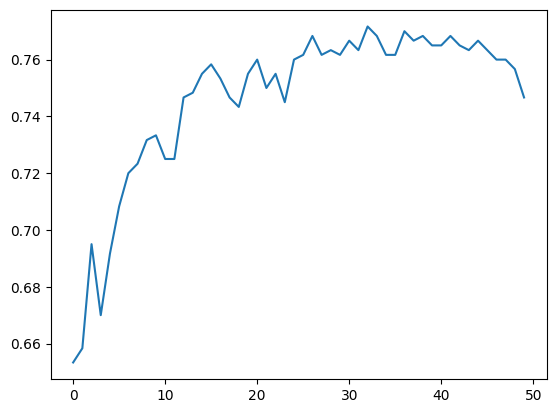

In [5]:
from sklearn.metrics import accuracy_score
accuracy_score(valid_labels, KNeighborsClassifier(n_neighbors=1).fit(train_values, train_labels).predict(valid_values))
scores = []
for k in range(1, 51):
    scores.append(accuracy_score(valid_labels, KNeighborsClassifier(n_neighbors=k).fit(train_values, train_labels).predict(valid_values)))
pl.plot(scores)

In [6]:
names_of_classifiers = [
    'KNeighbors',
    'DecisionTree',
    'SVClassifier',
    'Voting'
]

KNN33 = KNeighborsClassifier(n_neighbors=33)
DTE = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5)
SVBEST = SVC(C=2.4)

classifiers = [
    KNN33, DTE, SVBEST,
    VotingClassifier(estimators=[
        ('knn', KNN33),
        ('dt', DTE),
        ('svc', SVBEST)],
        voting='hard')]

In [7]:
mad_raw_valid_scores = {}
mad_raw_y_preds = {}

for name, clfr in zip(names_of_classifiers, classifiers):
    clfr.fit(train_values, train_labels)
    valid_score = clfr.score(valid_values, valid_labels)
    y_pred = clfr.predict(valid_values)

    mad_raw_valid_scores[name] = valid_score
    mad_raw_y_preds[name] = y_pred  

In [8]:
mad_raw_valid_scores

{'KNeighbors': 0.7716666666666666,
 'DecisionTree': 0.7933333333333333,
 'SVClassifier': 0.7033333333333334,
 'Voting': 0.7933333333333333}

Удаление шумовых объектов

In [9]:
z_scores_train = stats.zscore(train_values)
z_scores_valid = stats.zscore(valid_values)

threshold = 5

outliers_indices_train = np.where(np.abs(z_scores_train) > threshold)


In [10]:
train_values_filtered = np.delete(train_values, outliers_indices_train, 0)
train_labels_filtered = np.delete(train_labels, outliers_indices_train, 0)

print(train_values_filtered.shape)


(1992, 500)


In [11]:
mad_raw_valid_scores = {}
mad_raw_y_preds = {}

for name, clfr in zip(names_of_classifiers, classifiers):
    clfr.fit(train_values_filtered, train_labels_filtered)
    valid_score = clfr.score(valid_values, valid_labels)
    y_pred = clfr.predict(valid_values)

    mad_raw_valid_scores[name] = valid_score
    mad_raw_y_preds[name] = y_pred  

In [12]:
mad_raw_valid_scores

{'KNeighbors': 0.7716666666666666,
 'DecisionTree': 0.795,
 'SVClassifier': 0.705,
 'Voting': 0.7933333333333333}

Удаление шумовых признаков

In [13]:
train_df = pd.DataFrame(data=train_values[0:,0:],
                        index=[i for i in range(0, train_values.shape[0])],
                        columns=[i for i in range(0, train_values.shape[1])])

valid_df = pd.DataFrame(data=valid_values[0:,0:],
                        index=[i for i in range(0, valid_values.shape[0])],
                        columns=[i for i in range(0, valid_values.shape[1])])

In [17]:
# Вычисление матрицы корреляции
correlation_matrix = train_df.corr()

# Создание маски для идентификации признаков с корреляцией выше 90%
correlation_mask = correlation_matrix.abs() > 0.9

# Создание маски для верхнего треугольника матрицы (чтобы избежать повторений)
upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Применение маски к матрице корреляции
correlation_mask = correlation_mask & upper_triangle_mask

# Индексы признаков, которые нужно удалить
features_to_drop = [column for column in correlation_mask.columns if any(correlation_mask[column])]

# Удаление признаков с корреляцией выше 90%
train_df_filtered = train_df.drop(columns=features_to_drop)
valid_df_filtered = valid_df.drop(columns=features_to_drop)


# Вывод информации о удаленных признаках
print(f"Удалены признаки с корреляцией выше 90%: {features_to_drop}")

# Вывод отфильтрованного DataFrame

selected_train_values = train_df_filtered.values
selected_valid_values = valid_df_filtered.values

Удалены признаки с корреляцией выше 90%: [128, 281, 318, 336, 378, 433, 451, 472, 475, 493]


In [18]:
selected_train_values.shape

(2000, 490)

In [20]:
mad_raw_valid_scores = {}
mad_raw_y_preds = {}

for name, clfr in zip(names_of_classifiers, classifiers):
    clfr.fit(selected_train_values, train_labels)
    valid_score = clfr.score(selected_valid_values, valid_labels)
    y_pred = clfr.predict(selected_valid_values)

    mad_raw_valid_scores[name] = valid_score
    mad_raw_y_preds[name] = y_pred  

In [21]:
mad_raw_valid_scores

{'KNeighbors': 0.6716666666666666,
 'DecisionTree': 0.7716666666666666,
 'SVClassifier': 0.655,
 'Voting': 0.7233333333333334}

Нормализация

In [39]:
def myMinMaxScaler (df):
    '''
    PARAM(S):
    input is a pandas DataFrame
    lowerbound is the user-specified min (float)
    upperbound is the user-specified max (float)
    
    RETURNS:
    a transformed DataFrame whose values are between 0.0001 and 1
    '''
    mmdf = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
    return mmdf

In [40]:
train_df = pd.DataFrame(data=train_values[0:,0:],
                        index=[i for i in range(0, train_values.shape[0])],
                        columns=[i for i in range(0, train_values.shape[1])])

valid_df = pd.DataFrame(data=valid_values[0:,0:],
                        index=[i for i in range(0, valid_values.shape[0])],
                        columns=[i for i in range(0, valid_values.shape[1])])

In [41]:
train_df = myMinMaxScaler(train_df)
valid_df = myMinMaxScaler(valid_df)

In [42]:
train_values_norm = train_df.values
valid_values_norm = valid_df.values

In [43]:
mad_raw_valid_scores = {}
mad_raw_y_preds = {}

for name, clfr in zip(names_of_classifiers, classifiers):
    clfr.fit(train_values_norm, train_labels)
    valid_score = clfr.score(valid_values_norm, valid_labels)
    y_pred = clfr.predict(valid_values_norm)

    mad_raw_valid_scores[name] = valid_score
    mad_raw_y_preds[name] = y_pred

In [44]:
mad_raw_valid_scores

{'KNeighbors': 0.5966666666666667,
 'DecisionTree': 0.765,
 'SVClassifier': 0.5983333333333334,
 'Voting': 0.69}

Без шумовых объектов и признаков

In [48]:
train_df = pd.DataFrame(data=train_values_filtered[0:,0:],
                        index=[i for i in range(0, train_values_filtered.shape[0])],
                        columns=[i for i in range(0, train_values_filtered.shape[1])])

valid_df = pd.DataFrame(data=valid_values[0:,0:],
                        index=[i for i in range(0, valid_values.shape[0])],
                        columns=[i for i in range(0, valid_values.shape[1])])

In [50]:
train_values_filtered_norm = train_df.drop(columns=features_to_drop).values
valid_values_norm = valid_df.drop(columns=features_to_drop).values

In [51]:
mad_raw_valid_scores = {}
mad_raw_y_preds = {}

for name, clfr in zip(names_of_classifiers, classifiers):
    clfr.fit(train_values_filtered_norm, train_labels_filtered)
    valid_score = clfr.score(valid_values_norm, valid_labels)
    y_pred = clfr.predict(valid_values_norm)

    mad_raw_valid_scores[name] = valid_score
    mad_raw_y_preds[name] = y_pred

In [52]:
mad_raw_valid_scores

{'KNeighbors': 0.5283333333333333,
 'DecisionTree': 0.7716666666666666,
 'SVClassifier': 0.5716666666666667,
 'Voting': 0.66}